In [1]:
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

##### Load Data

In [2]:
with open('Data/count_ccs.json', 'r') as fp:
    count_ccs = json.load(fp)
 
    # Print the type of data variable
    print("Type:", type(count_ccs))

with open('Data/count_ccs_root.json', 'r') as fp:
    count_ccs_root = json.load(fp)

with open('Data/count_ccs_kw.json', 'r') as fp:
    count_ccs_kw = json.load(fp)

with open('Data/articles_dict.json', 'r') as fp:
    articles_dict = json.load(fp)

Type: <class 'dict'>


##### Descr of the Created DataFrame

In [3]:
articles_df = pd.DataFrame(articles_dict)
articles_df.tail()

,doi,abstract,ft_body,ccs,keywords
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"[online social media, machine learning, opinio..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"[researcher homepage classification, co-traini..."
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"[diversionary comments, classification, corefe..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"[estimation, clustering coefficient, sampling,..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"[aria, focus navigation, web accessibility]"


## Keyword Frequency and Ordering

In [4]:
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score 


def kl_div(x, y):
    """Function that computes the kl divergence of two discrete distributions"""
    idx1 = np.intersect1d(np.where(x>0), np.where(y>0))
    idx2 = np.where(x==0)

    return (x[idx1]*np.log(x[idx1]/y[idx1])).sum() + y[idx2].sum()

def ComputeKwDistribution(abstract, kw, normalized = True):
    """Function that returns the normalized(optional) distribution of words in a sentence"""
    abstract = abstract.lower()
    kw       = kw.lower()

    split1 = abstract.split(kw)

    positions = []
    phrase_length = 0
    for split_el in split1:
        # Replacing punctuations with spaces so they don't count as words
        clean = re.sub(r"""
               [,.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               split_el, flags=re.VERBOSE)

        temp_split = clean.split()
        phrase_length += len(temp_split)
        positions.append(phrase_length)

        phrase_length+=1 # Takes into account the kw

    positions = positions[:-1]
    phrase_length-=1#Removes the last kw added for nothing

    distribution = np.array([0 for i in range(phrase_length)])
    distribution[np.array(positions).astype(int)] = 1

    return distribution/distribution.sum() if normalized and distribution.sum()!=0 else distribution

    

def ExtractKeywordOrderFromAbstract(doi, abstract, ccs, labeled_data_dict, verbose=False):
    # Set abstract to lower case like concepts
    abstract = abstract.lower()
    if(verbose):
        print(abstract)
        print(ccs)

    # Convert ccs dict into dataframe and order the dataframe by importance
    ccs_df = pd.DataFrame({"ccs_concept": ccs.keys(), "importance": ccs.values()})
    ordered_ccs_array = ccs_df.sort_values("importance")["ccs_concept"].array[::-1]
    # pd.DataFrame({"keywords": count_ccs_kw[ccs_name].keys(), "occurences": count_ccs_kw[ccs_name].values()})

    concept_found = False
    i             = 0
    concept_root  = None
    concept_leaf  = None

    ## Loop that finds a concept root and leaf pair that is occuring in the abstract
    while(not concept_found and i < len(ordered_ccs_array) and ccs[ordered_ccs_array[i]] == 500):
        concept_tree = ordered_ccs_array[i].lower()
        i += 1

        # Identify concept root and leaf
        if('->' in concept_tree):
            concept_list = concept_tree.split("->")
            if(len(concept_list)<=2): continue
            concept_root = concept_list[1]
            concept_leaf = concept_list[-1]
        elif('~' in concept_tree):
            concept_list = concept_tree.split("~")
            if(len(concept_list)<=1): continue
            concept_root = concept_list[0]
            concept_leaf = concept_list[-1]
        else:
            continue

        # Check if the concepts are mentionned in abstract
        if(verbose):
            print("first concept: ", concept_root, "; second concept:", concept_leaf)
            print(concept_root in abstract)
            print(concept_leaf in abstract)
        
        if(concept_root in abstract and concept_leaf in abstract):
            concept_found = True
    
    if(not concept_found):
        return np.nan
    else:
        ## Randomly chooses the order of keywords (kw)
        label = None
        if(np.random.uniform(0,1)>0.5):
            label = 0 # leaf then root is 0
            kw1 = concept_leaf
            kw2 = concept_root

        else:
            label = 1 # root then leaf is 1
            kw2 = concept_leaf
            kw1 = concept_root
            

        ## Computing the distributions of both concepts
        dist1 = ComputeKwDistribution(abstract, kw1)
        dist2 = ComputeKwDistribution(abstract, kw2)

        ## Padding distributions to same length
        len_d1, len_d2 = len(dist1), len(dist2)
        if(len_d1 < len_d2):
            dist1 = np.pad(dist1, (0, len_d2-len_d1), mode="constant", constant_values=0)
        else:
            dist2 = np.pad(dist2, (0, len_d1-len_d2), mode="constant", constant_values=0)

        ## Computing entropy, KL divergence, ratio and Mutual Information for both distributions:
        H1_var = entropy(dist1)
        H2_var = entropy(dist2)
        kl_div1 = kl_div(dist1, dist2).sum()
        kl_div2 = kl_div(dist2, dist1).sum()
        ratio   = kl_div1/kl_div2 if kl_div2 != 0 else np.nan
        MI_var  = mutual_info_score(dist1, dist2) 

        ## Store information
        labeled_data_dict["doi"].append(doi)
        labeled_data_dict["label"].append(label)
        labeled_data_dict["kw1"].append(kw1)
        labeled_data_dict["kw2"].append(kw2)
        labeled_data_dict["distrib1"].append(dist1)
        labeled_data_dict["distrib2"].append(dist2)
        labeled_data_dict["H1"].append(H1_var)
        labeled_data_dict["H2"].append(H2_var)
        labeled_data_dict["DKL_1"].append(kl_div1)
        labeled_data_dict["DKL_2"].append(kl_div2)
        labeled_data_dict["ratio"].append(ratio)
        labeled_data_dict["MI"].append(MI_var)

        return 1

##### Create labeled data on abstracts

In [ ]:
## Dict stores the created labeled data for future experiments
labeled_data_dict = {"doi": [], "label": [], "kw1": [], "kw2": [], "distrib1": [], "distrib2": [], "H1": [], "H2": [], "DKL_1": [], "DKL_2": [], "ratio": [], "MI": []}


articles_with_abstract_df = articles_df.dropna(subset=['ccs', 'abstract'])
print("remaining articles", articles_with_abstract_df.shape)

return_na_count = articles_with_abstract_df.apply(lambda el: ExtractKeywordOrderFromAbstract(el.doi, el.abstract, el.ccs, labeled_data_dict, verbose=False), axis= 1)

print("number of concept not found:", return_na_count.isna().sum(), " out of {} articles.".format(articles_with_abstract_df.shape[0]))

labeled_data_df = pd.DataFrame.from_dict(labeled_data_dict)
labeled_data_df.tail()

In [6]:
labeled_data_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio,MI
count,138.000000,138.000000,138.000000,138.000000,138.000000,137.000000,138.000000
mean,0.528986,0.350373,0.331785,0.969615,0.991930,0.981161,0.000862
std,0.500978,0.477200,0.505025,0.186186,0.097995,0.155346,0.004674
min,0.000000,0.000000,0.000000,-0.346574,0.000000,-0.290470,0.000009
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000032
50%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000061
75%,1.000000,0.693147,0.693147,1.000000,1.000000,1.000000,0.000109
max,1.000000,2.079442,2.197225,1.000000,1.193147,1.000000,0.038761


##### Create labeled data on featured bodies

In [ ]:
labeled_data_bodies_dict = {"doi": [], "label": [], "kw1": [], "kw2": [], "distrib1": [], "distrib2": [], "H1": [], "H2": [], "DKL_1": [], "DKL_2": [], "ratio": [], "MI": []}


articles_with_bodies_df = articles_df.dropna(subset=['ccs', 'ft_body'])
print("remaining articles", articles_with_bodies_df.shape)

return_na_count = articles_with_bodies_df.apply(lambda el: ExtractKeywordOrderFromAbstract(el.doi, el.ft_body, el.ccs, labeled_data_bodies_dict, verbose=False), axis= 1)

print("number of concept not found:", return_na_count.isna().sum())

labeled_data_bodies_df = pd.DataFrame.from_dict(labeled_data_bodies_dict)
labeled_data_bodies_df.tail()

In [8]:
labeled_data_bodies_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio,MI
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4625.000000,4.706000e+03
mean,0.508287,0.951959,0.928631,0.990024,0.983413,0.807219,4.233143e-05
std,0.499984,1.271647,1.252910,0.281464,0.268231,2.841987,2.648827e-04
min,0.000000,0.000000,0.000000,-0.366204,-0.366204,-103.907629,3.432122e-10
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.435807e-08
50%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,8.131952e-08
75%,1.000000,1.609438,1.609438,1.000000,1.000000,1.000000,4.279985e-07
max,1.000000,5.796058,5.880533,5.430887,5.189767,6.522787,5.607743e-03


##### Gradient Boosting

In [9]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_data_bodies_df.drop(columns=["kw1", "kw2", "distrib1", "distrib2", "doi"]).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [10]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [11]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.5423438443238353

In [12]:
best_model = gsearch1.best_estimator_

In [13]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [14]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [15]:
y_pred=best_model.predict(X_test)
y_pred

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,

In [16]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.5622


Text(0, 0.5, 'Feature Importance Score')

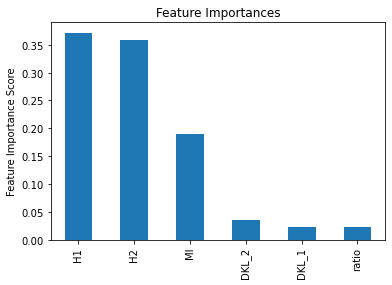

In [17]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

In [18]:
cm = confusion_matrix(y_test, y_pred)

In [19]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[331 123]
 [282 189]]


<AxesSubplot:>

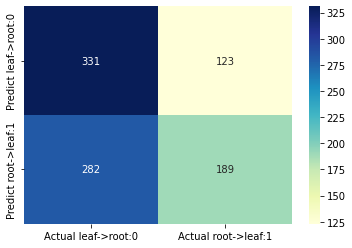

In [20]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.73      0.62       454
           1       0.61      0.40      0.48       471

    accuracy                           0.56       925
   macro avg       0.57      0.57      0.55       925
weighted avg       0.57      0.56      0.55       925



##### Save Models

In [22]:
pickle.dump(best_model, open("Models/naive_gridsearch.pkl", "wb"))

In [23]:
best_model = pickle.load(open("Models/naive_gridsearch.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)